***Importing Required Libraries***

In [3]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()


import re
import time
import nltk
import praw
import string
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec


from sklearn.model_selection import train_test_split

import nltk
from nltk.collocations import *
from nltk import FreqDist, word_tokenize
from nltk.corpus import gutenberg, stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from keras.preprocessing import text
from keras.models import Model, model_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D


from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Acquiring User Likes


## Using Twitter API

In [16]:
### Acquired from Twitter using API key and API secret key ###
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAImyAwEAAAAAyWB9oAfMqhJG66%2BeJHuUEi5wsXM%3DKOzTDPgjqoXjzERO1JmoAJfVIqjnaPdD7wUhayNjESzeytty2J' # Bearer Token


In [188]:
def get_liked_tweets(handle):
    '''
    Takes Twitter handle and extracts and parses liked tweets.
    
    '''
    all_tweets = []
    url = 'https://api.twitter.com/1.1/favorites/list.json?screen_name={}'.format(handle)
    headers = {
        'Authorization': 'Bearer {}'.format(bearer_token),
            }
    first_url_params = {
        'count': 200
            }
    first_response = requests.get(url, headers=headers, params=first_url_params)
    print(first_response)
    first_initial_split = first_response.text.split(',"text":"')
    first_t = len(first_initial_split)    
    for i in range(1,first_t):
        all_tweets.append(first_initial_split[i].split(',"truncated":')[0])
        
    ### Regex to extract the id of the last tweet to use as pagination ###      
    regsearch = re.search('(?<=(\d","id":))[\d]*', first_initial_split[first_t-2])
    tweet_id = int(regsearch.group(0))
    ###
    print(tweet_id)
    
    ### Looping process to manually paginate through tweets ###
    page = 0
    while page < 15:
        url1 = 'https://api.twitter.com/1.1/favorites/list.json?screen_name={}&count=200&max_id={}'.format(handle,tweet_id-1)
        response = requests.get(url1, headers=headers)
        print(response)
        initial_split = response.text.split(',"text":"')
        t = len(initial_split)
        print(t)
        for i in range(1,t):
            all_tweets.append(initial_split[i].split(',"truncated":')[0])
 
        ### Regex to extract the id of the last tweet to use as pagination ###      
        
        try:
            regsearch = re.search('(?<=(\d","id":))[\d]*', initial_split[t-2])
            tweet_id = int(regsearch.group(0))
            print(tweet_id)
        except: break
        ###
        page +=1
    return all_tweets

# Getting Top Subreddits

In [25]:
driver = webdriver.Chrome()
driver.get('https://www.reddit.com/r/TheoryOfReddit/comments/1f7hqc/the_200_most_active_subreddits_categorized_by/')

In [26]:
subs = driver.find_elements_by_class_name('_1qeIAgB0cPwnLhDF9XSiJM')
subreddits = []
for i in subs[3:]:
    if "r/" in i.text:
        subreddits.append(i.text.split(" - ")[1])
    else:
        continue
### THIS CELL THROWS AN ERROR -- IGNORE IT -- ###

In [28]:
clean_subs = []
for sub in subreddits:
    clean_subs.append(sub.split('r/')[1])

## Using PRAW (Python Reddit API Wrapper) to get top posts in top subreddits

In [38]:
reddit = praw.Reddit(client_id='MU9yce7zmiOKwA',
                     client_secret='DRV5fO7p-Tn7VzxmMH8mnRwM_hE',
                     user_agent='my user agent')

In [11]:
all_submissions = {}
for sub in tqdm(clean_subs):
    all_submissions[sub] = []
    for submission in reddit.subreddit(sub).top(limit=1000):
        all_submissions[sub].append(submission.title)
    

## Looking at examples of pre-processing and EDA

In [22]:
lemmatizer = WordNetLemmatizer()

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
subr_text_tokens_raw = nltk.regexp_tokenize(" ".join(all_submissions['creepy']), pattern)
subr_text_tokens = [word.lower() for word in subr_text_tokens_raw]
subr_text_tokens = [lemmatizer.lemmatize(i) for i in subr_text_tokens]
subr_text_freqdist = FreqDist(subr_text_tokens)
subr_text_freqdist.most_common(200)

NameError: name 'all_submissions' is not defined

In [35]:
subr_text_stopped_freqdist = FreqDist(subr_text_stopped)
subr_text_stopped_freqdist.most_common(50)

[('skull', 29),
 ('found', 27),
 ('r', 22),
 ('night', 20),
 ('like', 20),
 ('man', 18),
 ('old', 18),
 ('death', 16),
 ('year', 16),
 ('human', 16),
 ('post', 15),
 ('creepy', 14),
 ('bone', 14),
 ('one', 14),
 ('picture', 14),
 ('look', 14),
 ('made', 14),
 ('mask', 14),
 ('skeleton', 13),
 ('friend', 12),
 ('abandoned', 12),
 ('monster', 12),
 ('statue', 12),
 ('x', 12),
 ('wood', 11),
 ('water', 11),
 ('people', 11),
 ('face', 11),
 ('last', 11),
 ('thing', 11),
 ('inside', 10),
 ('back', 10),
 ('house', 10),
 ('dead', 10),
 ('church', 10),
 ('forest', 10),
 ('got', 10),
 ('head', 10),
 ('dark', 10),
 ('museum', 10),
 ('nightmare', 10),
 ('baby', 9),
 ('remains', 9),
 ('teeth', 9),
 ('catacomb', 9),
 ('tree', 9),
 ('boris', 9),
 ('groh', 9),
 ('something', 9),
 ('photo', 9)]

In [32]:
total_word_count = sum(subr_text_stopped_freqdist.values())
subr_text_top_50 = subr_text_stopped_freqdist.most_common(50)
print("Word\t\t\tNormalized Frequency")
for word in subr_text_top_50:
    normalized_frequency = word[1] / total_word_count
    print("{} \t\t\t {:.4}".format(word[0], normalized_frequency))

Word			Normalized Frequency
guy 			 0.005921
man 			 0.005702
car 			 0.005482
found 			 0.005044
like 			 0.005044
one 			 0.004386
house 			 0.004167
new 			 0.003947
wtf 			 0.003947
time 			 0.003947
back 			 0.003947
day 			 0.003728
year 			 0.003509
look 			 0.003509
ha 			 0.003289
work 			 0.003289
fire 			 0.003289
fish 			 0.003289
got 			 0.003289
today 			 0.00307
way 			 0.002851
see 			 0.002851
well 			 0.002851
snake 			 0.002851
night 			 0.002632
road 			 0.002632
inside 			 0.002412
think 			 0.002412
going 			 0.002412
baby 			 0.002412
last 			 0.002412
get 			 0.002412
made 			 0.002193
eye 			 0.002193
someone 			 0.002193
head 			 0.002193
driver 			 0.002193
thing 			 0.001974
even 			 0.001974
happen 			 0.001974
fuck 			 0.001974
i'm 			 0.001974
wait 			 0.001974
building 			 0.001974
right 			 0.001974
little 			 0.001974
water 			 0.001974
driving 			 0.001974
go 			 0.001974
live 			 0.001974


In [41]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

subr_text_finder = BigramCollocationFinder.from_words(subr_text_stopped)
subr_text_finder.apply_freq_filter(3)

subr_text_scored = subr_text_finder.score_ngrams(bigram_measures.pmi)
subr_text_scored[:20]

# Separating subreddits into respective categories

In [376]:
label_text_df = pd.DataFrame()

label_text_df['target'] = ['Discussion and Stories','Emotional Reaction Fuel','Entertainment - Gaming', 
                         'Entertainment - Television', 'Entertainment - Other (Movies/Music/Franchies/Misc)',
                         'Humor','Images, Gifs, and Videos','Learning and Thinking','Lifestyle and Help',
                         'News and Issues', 'Places', 'Race, Gender, and Identity', 'Sports','Technology']
categorized_posts = dict((i,"")for i in label_text_df.target)
for i in clean_subs:
    if i =="AskReddit" or i=='IAmA' or i =="bestof" or i=='fatpeoplestories' or i =='pettyrevenge' or i =="TalesFromRetail" or i=='DoesAnybodyElse' or i =='CrazyIdeas':
        categorized_posts['Discussion and Stories'] = [categorized_posts['Discussion and Stories'],all_submissions[i]]
    elif i =="WTF" or i=='aww' or i =="cringepics" or i=='JusticePorn' or i =='MorbidReality' or i =="rage" or i=='mildlyinfuriating' or i =='creepy' or i=='creepyPMs' or i =="nosleep" or i=='nostalgia':
        categorized_posts['Emotional Reaction Fuel'] = [categorized_posts['Emotional Reaction Fuel'],all_submissions[i]]
    elif i =="gaming" or i=='leagueoflegends' or i =="pokemon" or i=='Minecraft' or i =='starcraft' or i =="Games" or i=='DotA2' or i =='skyrim' or i=='tf2' or i =="magicTCG" or i=='wow' or i =="KerbalSpaceProgram" or i=='mindcrack' or i =='Fallout' or i=='roosterteeth' or i =="Planetside" or i=='gamegrumps' or i =="battlefield3" or i=='zelda' or i =='darksouls' or i=='masseffect':
        categorized_posts['Entertainment - Gaming'] = [categorized_posts['Entertainment - Gaming'],all_submissions[i]]
    elif i =="arresteddevelopment" or i=='gameofthrones' or i =="doctorwho" or i=='mylittlepony' or i =='community' or i =="breakingbad" or i=='adventuretime' or i =='startrek' or i=='TheSimpsons' or i =="futurama" or i=='HIMYM' or i=='DunderMifflin' or i =="thewalkingdead":
        categorized_posts['Entertainment - Television'] = [categorized_posts['Entertainment - Television'],all_submissions[i]]
    elif i =="Music" or i=='movies' or i =="harrypotter" or i=='StarWars' or i =='DaftPunk' or i =="hiphopheads" or i=='anime' or i =='comicbooks' or i=='geek' or i =="batman" or i=='TheLastAirbender' or i=='Naruto' or i =="FanTheories":
        categorized_posts['Entertainment - Other (Movies/Music/Franchies/Misc)'] = [categorized_posts['Entertainment - Other (Movies/Music/Franchies/Misc)'],all_submissions[i]]
    elif i =="funny" or i=='AdviceAnimals' or i =="fffffffuuuuuuuuuuuu" or i=='4chan' or i =='ImGoingToHellForThis' or i =="firstworldanarchists" or i=='circlejerk' or i =='MURICA' or i=='facepalm' or i =="Jokes" or i=='wheredidthesodago' or i=='polandball' or i =="TrollXChromosomes" or i =="comics" or i=='nottheonion' or i=='britishproblems' or i =="TumblrInAction" or i =="onetruegod":
        categorized_posts['Humor'] = [categorized_posts['Humor'],all_submissions[i]]
    elif i =="pics" or i=='videos' or i =="gifs" or i=='reactiongifs' or i =='mildlyinteresting' or i =="woahdude" or i=='FiftyFifty' or i =='FoodPorn' or i=='HistoryPorn' or i =="wallpapers" or i=='youtubehaiku' or i=='Unexpected' or i =="photoshopbattles" or i =="AnimalsBeingJerks" or i=='cosplay' or i=='EarthPorn' or i =="QuotesPorn" or i =="awwnime" or i =="AbandonedPorn" or i=='carporn' or i =="PerfectTiming" or i=='OldSchoolCool' or i =='RoomPorn' or i =="woahdude" or i=='Pareidolia' or i =='MapPorn' or i=='tumblr' or i =="techsupportgore" or i=='PrettyGirls' or i=='itookapicture':
        categorized_posts['Images, Gifs, and Videos'] = [categorized_posts['Images, Gifs, and Videos'],all_submissions[i]]
    elif i =="todayilearned" or i=='science' or i =="askscience" or i=='space' or i =='AskHistorians' or i =="YouShouldKnow" or i=='explainlikeimfive':
        categorized_posts['Learning and Thinking'] = [categorized_posts['Learning and Thinking'],all_submissions[i]]
    elif i =="trees" or i=='MakeupAddiction' or i =="cats" or i=='LifeProTips' or i =='RedditLaqueristas' or i =="Random_Acts_Of_Amazon" or i=='food' or i =='guns' or i=='tattoos' or i =="corgi" or i=='teenagers' or i =='GetMotivated' or i=='motorcycles' or i =="sex" or i=='progresspics' or i =='DIY' or i=='bicycling' or i =="Fitness" or i=='lifehacks' or i =='longboarding' or i=='Frugal' or i =="drunk" or i=='Art' or i=='loseit' or i =='Military':
        categorized_posts['Lifestyle and Help'] = [categorized_posts['Lifestyle and Help'],all_submissions[i]]
    elif i =="politics" or i=='worldnews' or i =="news" or i=='conspiracy' or i =='Libertarian' or i =="TrueReddit" or i=='Conservative' or i=='offbeat':
        categorized_posts['News and Issues'] = [categorized_posts['News and Issues'],all_submissions[i]]
    elif i =="canada" or i=='toronto' or i =="australia" or i=='unitedkingdom':
        categorized_posts['Places'] = [categorized_posts['Places'],all_submissions[i]]
    elif i =="atheism" or i=='TwoXChromosomes' or i =="MensRights" or i=='gaybros' or i =='lgbt':
        categorized_posts['Race, Gender, and Identity'] = [categorized_posts['Race, Gender, and Identity'],all_submissions[i]]
    elif i =="nba" or i=='soccer' or i =="hockey" or i=='nfl' or i =='formula1' or i =="baseball" or i=='MMA' or i=='SquaredCircle':
        categorized_posts['Sports'] = [categorized_posts['Sports'],all_submissions[i]]
    elif i =="technology" or i=='Android' or i =="Bitcoin" or i=='programming' or i =='apple':
        categorized_posts['Technology'] = [categorized_posts['Technology'],all_submissions[i]]

## Creating dataframe of posts and categories

In [380]:
def flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i
posts_by_category = dict((i,"")for i in label_text_df.target)
for i in label_text_df.target:
    posts_by_category[i] = list(flatten(categorized_posts[i]))[1:]

In [383]:
master_list = []
for i in tqdm(label_text_df.target):
    for post in posts_by_category[i]:
        post_list = []
        post_list.append(i)
        post_list.append(post)
        master_list.append(post_list)
        
#     posts_by_category[i] = " ".join(posts_by_category[i])

In [392]:
reddit_df = pd.DataFrame(master_list)

In [393]:
reddit_df.to_csv('reddit_df')

In [400]:
reddit_df.head(2)

,0,1
0,Discussion and Stories,"People who haven't pooped in 2019 yet, why are..."
1,Discussion and Stories,Stan Lee has passed away at 95 years old


In [4]:
reddit_df = pd.read_csv('reddit_df')

In [5]:
reddit_df = reddit_df.drop(columns=["Unnamed: 0"])
reddit_df.columns = reddit_df.columns.astype("int")

# Using GloVes multi-dimensional word vectorizer to build baseline models

In [29]:
target = reddit_df[0]

In [28]:
data = reddit_df[1].map(word_tokenize).values

KeyboardInterrupt: 

In [675]:
total_vocabulary = set(word for headline in data for word in headline)
print("There are {} unique tokens in the dataset.".format(len(total_vocabulary)))

There are 111821 unique tokens in the dataset.


In [676]:
glove = {}
with open('glove.6B.300d.txt', 'rb') as f:            ## I used the 100-dimensional file to vectorize for the building
    for line in f:                                    # of the model, change to 300-dimensional for final model
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [677]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note from Mike: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # It can't be used in a sklearn Pipeline. 
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [679]:
rf =  Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ("Random Forest", RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])
models = [('Random Forest', rf),
          ("Support Vector Machine", svc),
          ("Logistic Regression", lr)]

In [412]:
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in tqdm(models)]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.2s finished
/Users/reuben/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/reuben/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: Fut

In [413]:
scores

[('Random Forest', 0.2268008048957078),
 ('Support Vector Machine', 0.24213128541066958),
 ('Logistic Regression', 0.2312619396923426)]

## Initial results seem low, but, with 14 categories, random guessing would achieve an accuracy of 7.1%. Let's try a Deep Neural Network with and Embedding Layer

In [30]:
y = pd.get_dummies(target).values
reddit_df['splitted'] = reddit_df[1].apply(lambda x: x.split())

In [658]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]
reddit_df['text_lemmatized'] = reddit_df.splitted.apply(lemmatize_text)

In [661]:
reddit_df[1] = reddit_df.text_lemmatized.apply(lambda x: " ".join(x))

In [197]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(reddit_df[1]))
list_tokenized_headlines = tokenizer.texts_to_sequences(reddit_df[1])
X_t = pad_sequences(list_tokenized_headlines, maxlen=100)

In [664]:
# #########################
# #   CURRENT BEST MODEL  #  --- Epoch 1: 15.6% accurate
# #########################  --- Epoch 50: 49.4%

#embedding_size = 300
# input_ = Input(shape=(50,))
# x = Embedding(20000, embedding_size)(input_)
# x = Dense(750, activation='relu', kernel_regularizer=regularizers.l2(0.2))(x)

# x = LSTM(25, return_sequences=True)(x)
# x = GlobalMaxPool1D()(x)
# x = Dense(500, activation='relu')(x)
# x = Dropout(0.2)(x)
# # There are 14 different possible classes, so we use 14 neurons in our output layer
# x = Dense(14, activation='softmax')(x)

# model = Model(inputs=input_, outputs=x)
# model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
# X_train,X_val, y_train,y_val = train_test_split(X_t,y,test_size=0.1,random_state=1)
# model.summary()

**Neural Network initially kept having a val_accuracy of 0... because the data is sitting in order and wasn't shuffled! (the "test_size" is just the very last bit (0.2) of the data, it doesn't choose randomly... fixed with train test split, which shuffles by default!**

## Training model with stopwords removed from post titles

In [ ]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

In [9]:
reddit_df_stopped = pd.DataFrame()
reddit_df_stopped[0] = reddit_df[0]
reddit_df_stopped[1] = reddit_df[1].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))


In [10]:
tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(list(reddit_df_stopped[1]))
list_tokenized_headlines = tokenizer.texts_to_sequences(reddit_df_stopped[1])
X_t = pad_sequences(list_tokenized_headlines, maxlen=50)

In [44]:
embedding_size = 300
input_ = Input(shape=(50,))
x = Embedding(20000, embedding_size)(input_)
x = Dense(750, activation='relu', kernel_regularizer=regularizers.l2(0.2))(x)

x = LSTM(25, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(500, activation='relu')(x)
x = Dropout(0.2)(x)
# There are 14 different possible classes, so we use 14 neurons in our output layer
x = Dense(14, activation='softmax')(x)

model = Model(inputs=input_, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
X_train,X_val, y_train,y_val = train_test_split(X_t,y,test_size=0.3,random_state=1)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 50, 300)           6000000   
_________________________________________________________________
dense_10 (Dense)             (None, 50, 750)           225750    
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 25)            77600     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 25)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 500)               13000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0   

In [46]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(X_train, y_train, epochs=100, batch_size=500, callbacks=[earlyStopping,mcp_save], shuffle=True, validation_data=(X_val,y_val))


/Users/reuben/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 121138 samples, validate on 51917 samples
Epoch 1/100
121138/121138 [==============================] - 274s 2ms/step - loss: 6.9767 - accuracy: 0.1666 - val_loss: 2.3905 - val_accuracy: 0.1804
Epoch 2/100
121138/121138 [==============================] - 264s 2ms/step - loss: 2.2183 - accuracy: 0.2359 - val_loss: 2.1184 - val_accuracy: 0.2883
Epoch 3/100
121138/121138 [==============================] - 264s 2ms/step - loss: 2.0414 - accuracy: 0.3067 - val_loss: 2.0377 - val_accuracy: 0.3097
Epoch 4/100
121138/121138 [==============================] - 264s 2ms/step - loss: 1.9735 - accuracy: 0.3324 - val_loss: 1.9986 - val_accuracy: 0.3272
Epoch 5/100
121138/121138 [==============================] - 264s 2ms/step - loss: 1.9248 - accuracy: 0.3524 - val_loss: 1.9765 - val_accuracy: 0.3409
Epoch 6/100
121138/121138 [==============================] - 265s 2ms/step - loss: 1.8839 - accuracy: 0.3755 - val_loss: 1.9298 - val_accuracy: 0.3657
Epoch 7/100
121138/121138 [================

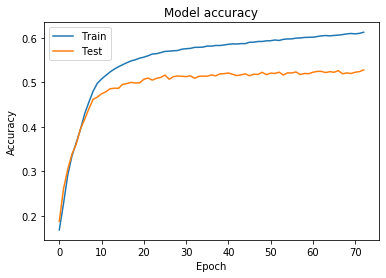

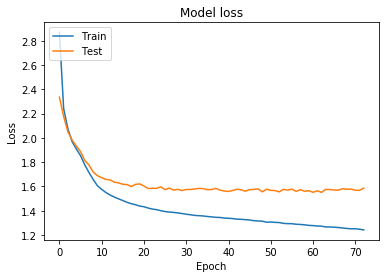

In [1023]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [144]:
model.evaluate(X_val,y_val) ###  Quick sanity check

51917/51917 [==============================] - 64s 1ms/step


[1.6394625541404604, 0.5006067156791687]

# Calculating probability of what category you like based on tweets!

In [877]:
json_file = open('model.json', 'r')                        ### Loading my best model
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
loaded_model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

Loaded model from disk


In [186]:
def RedditCategoryPredictor():
    twitter_handle = input("What is your Twitter Handle?")
    likes = get_liked_tweets(twitter_handle)
    print(len(set(likes)))
    tweets_stopped = []
    for sentence in set(likes):
        tweets_stopped.append([word for word in sentence.split() if word not in stopwords and "\\" not in word and "@" not in word and "#" not in word and len(word) > 2 and "$" not in word and "---" not in word])
    tweets_stopped_and_lemmatized = []
    for sentence in tweets_stopped:
        tweets_stopped_and_lemmatized.append([lemmatizer.lemmatize(word) for word in sentence])
    print(tweets_stopped_and_lemmatized)
    
                                            
    tokenizer1 = text.Tokenizer(num_words=30000)
    tokenizer1.fit_on_texts(tweets_stopped_and_lemmatized)
    list_tokenized_tweets = tokenizer.texts_to_sequences(tweets_stopped_and_lemmatized)
    X_t1 = pad_sequences(list_tokenized_tweets, maxlen=50)
    result_probabilities = model.predict(X_t1)
    result = result_probabilities.argmax(axis=1)
    print(result_probabilities.shape)
    unique_elements, counts_elements = np.unique(result, return_counts=True)
    print(unique_elements)
    print(counts_elements)
    winning_category = list(counts_elements).index(max(counts_elements))
    suggested_cat = None
    if winning_category == 0:
        suggested_cat = "Discussion and Stories"
    elif winning_category == 1:
        suggested_cat = "Emotional Reaction Fuel"
    elif winning_category == 2:
        suggested_cat = "Entertainment - Gaming"
    elif winning_category == 3:
        suggested_cat = "Entertainment - Other (Movies/Music/Franchies/Misc)"
    elif winning_category == 4:
        suggested_cat = "Entertainment - Television"
    elif winning_category == 5:
        suggested_cat = "Humor"
    elif winning_category == 6:
        suggested_cat = "Images, Gifs, and Videos"
    elif winning_category == 7:
        suggested_cat = "Learning and Thinking"
    elif winning_category == 8:
        suggested_cat = "Lifestyle and Help"
    elif winning_category == 9:
        suggested_cat = "News and Issues"
    elif winning_category == 10:
        suggested_cat = "Places"
    elif winning_category == 11:
        suggested_cat = "Race, Gender, and Identity"
    elif winning_category == 12:
        suggested_cat = "Sports"
    elif winning_category == 13:
        suggested_cat = "Technology"
    return suggested_cat

## Test

In [189]:
techcrunch = RedditCategoryPredictor()
techcrunch

What is your Twitter Handle?bonappetit
<Response [200]>
1118165736181071878
<Response [200]>
245
989690098844348417
<Response [200]>
217
907004729825169408
<Response [200]>
237
877870311630188544
<Response [200]>
232
804786709661700096
<Response [200]>
210
778324481408323585
<Response [200]>
215
765564828761133056
<Response [200]>
225
758706004766760961
<Response [200]>
213
738014056599162881
<Response [200]>
219
718113355404296193
<Response [200]>
215
704489403658407936
<Response [200]>
228
691325434554781698
<Response [200]>
220
667724637200097280
<Response [200]>
201
642372690817380353
<Response [200]>
218
620662353567346688
<Response [200]>
201
596343215306866688
3417
[['never', 'knew', 'needed', 'marshmallow', 'crossbow,', 'thank', 'you.', '*adds', 'christmas', 'list*'], ['hmmm...', 'thinking', 'breakfast', 'mug', 'cake', 'talked'], ['Guys', 'launched', 'merch', 'need', 'feel', 'targeted', 'millennial', 'excited', 'embrace'], ['name', 'Twitter', 'Apple', 'number', 'million', "they

(3417, 14)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[132 134 615 150 282 736 391  15 773  40  10  17  75  47]


'Lifestyle and Help'

In [175]:
reddit_df_stopped[0].value_counts()

Images, Gifs, and Videos                               28489
Lifestyle and Help                                     24503
Entertainment - Gaming                                 20862
Humor                                                  17844
Entertainment - Other (Movies/Music/Franchies/Misc)    12927
Entertainment - Television                             12925
Emotional Reaction Fuel                                10912
Sports                                                  7979
News and Issues                                         7978
Discussion and Stories                                  7937
Learning and Thinking                                   6815
Technology                                              4962
Race, Gender, and Identity                              4948
Places                                                  3974
Name: 0, dtype: int64

## Getting Related Subreddits

In [31]:
driver = webdriver.Chrome()
driver.get('https://anvaka.github.io/redsim/')

In [32]:
related_subreddits = {}
for i in clean_subs:
    searchbox = driver.find_element_by_id('search-input')
    searchbox.send_keys(i)
    driver.find_element_by_class_name('btn').click()
    result_subs = driver.find_elements_by_xpath("//div[contains(@ng-repeat, 'sub in to')]")
    for s in result_subs:
        related_subreddits.setdefault(i,[]).append(s.text) 
    driver.find_element_by_id('search-input').clear()
        

In [33]:
list(related_subreddits.values())[2]

['technology', 'science', 'politics']

In [36]:
related_subreddits

{'AskReddit': ['funny',
  'pics',
  'todayilearned',
  'videos',
  'WTF',
  'AdviceAnimals',
  'gaming',
  'gifs',
  'news',
  'worldnews',
  'movies'],
 'IAmA': ['todayilearned'],
 'bestof': ['technology', 'science', 'politics'],
 'fatpeoplestories': ['fatlogic',
  'TalesofFatHate',
  'neckbeardstories',
  'weeabootales',
  'TalesFromRetail',
  'pettyrevenge',
  'fatpeoplehate',
  'TumblrInAction'],
 'pettyrevenge': ['TalesFromRetail',
  'ProRevenge',
  'talesfromtechsupport',
  'fatpeoplestories',
  'JusticePorn',
  'TalesFromYourServer'],
 'TalesFromRetail': ['talesfromtechsupport',
  'pettyrevenge',
  'TalesFromYourServer',
  'TalesFromTheCustomer',
  'IDontWorkHereLady',
  'fatpeoplestories'],
 'CrazyIdeas': ['NoStupidQuestions',
  'Lightbulb',
  'Unexpected',
  'OutOfTheLoop',
  'mildlyinfuriating'],
 'WTF': ['pics',
  'funny',
  'AdviceAnimals',
  'todayilearned',
  'videos',
  'gifs',
  'gaming',
  'worldnews',
  'AskReddit',
  'news',
  'aww',
  'movies'],
 'aww': ['pics',
  '

In [39]:
all_related_posts = {}
for related_subs in tqdm(list(related_subreddits.values())):
    related_sub_posts = []
    for sub in tqdm(related_subs):
        try:
            for submission in reddit.subreddit(sub).top(limit=1000):
                related_sub_posts.append(submission.title)
            related_sub_posts.append(sub)
        except:
            continue
    all_related_posts.append(related_sub_posts)

In [59]:
len(all_related_posts[0])

10931

In [76]:
(all_related_posts[0][8000:])

['A suspected big cat poacher has been eaten by lions near the Kruger National Park in South Africa, police say',
 'Chris Brown detained on suspicion of rape',
 'Comcast deleted net neutrality pledge the same day FCC announced repeal',
 'Senate approves bill to extend 9/11 victims fund',
 'Hate crime charges filed against 4 in torture of teen',
 'Rhino poacher trampled to death by elephant; remains eaten by lions',
 'Jeffrey Epstein Death: 2 Guards Slept Through Checks and Falsified Records',
 'YouTube suspends Logan Paul’s ad revenue, blames ‘recent pattern of behavior',
 'Michigan becomes the 10th state to legalize recreational marijuana',
 'Terry Crews Testifies Before Senate On Sexual Assault, Says He Won’t Be In ‘Expendables 4’ After Producer Threatened “Trouble”',
 'Comcast asks the FCC to prohibit states from enforcing net neutrality',
 'Corey Feldman launches campaign to expose Hollywood pedophile ring',
 "A principal in Florida said he couldn't confirm the Holocaust was a 'fac

In [41]:
def tokenize(text):
    combined_titles = ""
    for title in text:
        combined_titles += title + " "
    return word_tokenize(combined_titles)


In [42]:
def count_vectorize(text, vocab=None):
    if vocab:
        unique_words = vocab
    else:
        unique_words = list(set(text))
    
    word_dict = {i:0 for i in unique_words}
    
    for word in text:
        word_dict[word] += 1
    
    return word_dict


In [44]:
for sub in clean_subs:
    tokenized_words = tokenize(all_submissions[sub])
    counted_words = count_vectorize(tokenized_words)
    print(counted_words)
    

{'all': 3, 'law': 3, 'top': 1, 'for': 1, 'makes': 1, 'them': 1, 'about': 5, 'last': 1, 'such': 1, 'upvoted': 1, 'shutdowns': 1, 'people': 1, 'signs': 1, 'the': 8, 'future': 1, 'specialized': 1, '[': 1, 'your': 1, 'days': 1, 'go': 1, 'employees': 1, 'become': 1, 'What': 1, 'stations': 1, 'do': 5, 'wants': 1, 'original': 1, 'other': 1, 'putting': 1, 'Americans': 1, 'series': 1, 'guy': 3, 'be': 2, 'still': 1, 'my': 1, 'pass': 1, 'what': 3, 'a': 8, 'cartoons': 1, 'strategems': 1, 'with': 2, 'not': 1, 'while': 1, 'People': 1, 'radio': 1, 'Iceland': 1, 'over': 2, 'Anthony': 1, 'every': 1, 'where': 1, 'someone': 1, 'noises': 1, 'life': 1, 'donors': 1, '18': 1, 'test': 1, 'of': 6, 'news': 1, "'s": 1, 'lay': 1, '95': 1, 'difficult': 1, 'pot': 1, 'as': 1, 'federal': 1, 'like': 1, 'automatically': 2, 'five': 1, 'Bourdain': 1, 'smoke': 1, 'category': 1, 'commercials': 1, 'crosspost': 1, 'in': 7, 'these': 1, 'requires': 1, 'why': 2, 'pooped': 1, 'years': 2, 'Lee': 1, 'How': 3, 'government': 1, '201

{'against': 1, 'law': 1, 'for': 1, 'clients': 1, 'DOM': 1, 'hard': 1, 'implemented': 1, 'alternative': 1, 'admit': 1, 'tens': 1, 'called': 1, 'PR': 1, 'free': 1, 'people': 1, 'Polymer': 1, 'the': 5, 'wrong': 1, 'They': 1, 'spent': 1, 'v0': 1, '(': 2, 'did': 1, 'JavaScript': 1, 'start': 1, 'algorithms': 1, 'Bounty': 1, 'The': 1, 'Paid': 1, 'WPF': 1, 'somebody': 1, 'really': 1, 'character': 1, 'programming': 1, 'my': 2, 'a': 7, 'Edge': 1, 'always': 1, 'work': 1, 'programmers': 1, 'read': 1, '$': 1, 'Bug': 1, 'open': 1, 's': 2, 'x-post': 1, 'OptiKey': 1, 'IKEA': 1, 'over': 1, 'probably': 1, 'load': 1, 'slower': 1, 'where': 1, 'tracking': 1, 'reason': 2, 'redesign': 1, 'of': 8, 'explains': 1, 'Google': 2, "'s": 3, 'CPU': 1, 'their': 1, 'as': 3, 'interesting': 1, 'Intel': 1, '“': 1, 'Got': 1, 'TIL': 1, 'dwitter': 1, 'instruction': 1, 'spare': 1, '140': 1, 'YouTube': 2, 'inside': 1, 'mess': 2, 'in': 4, 'compose': 1, 'patenting': 1, ':': 3, 'harder': 1, '5x': 1, 'needs': 1, 'software': 1, 'ye

In [80]:
def term_frequency(BoW_dict):
    total_word_count = sum(BoW_dict.values())
    for ind, val in BoW_dict.items():
        BoW_dict[ind] = val/ total_word_count
    
    return BoW_dict   

In [126]:
def inverse_document_frequency(list_of_dicts):
    vocab_set = set()
    # Iterate through list of dfs and add index to vocab_set
    for d in list_of_dicts:
        for word in d.keys():
            vocab_set.add(word)
    
    # Once vocab set is complete, create an empty dictionary with a key for each word and value of 0.
    full_vocab_dict = {i:0 for i in vocab_set}
    
    # Loop through each word in full_vocab_dict
    for word, val in full_vocab_dict.items():
        docs = 0
        
        # Loop through list of dicts.  Each time a dictionary contains the word, increment docs by 1
        for d in list_of_dicts:
            if word in d:
                docs += 1
        
        # Now that we know denominator for equation, compute and set IDF value for word
        
        full_vocab_dict[word] = np.log((len(list_of_dicts)/ float(docs)))
    
    return full_vocab_dict

In [127]:
def tf_idf(list_of_dicts):
    # Create empty dictionary containing full vocabulary of entire corpus
    doc_tf_idf = {}
    idf = inverse_document_frequency(list_of_dicts)
    full_vocab_list = {i:0 for i in list(idf.keys())}
    
    # Create tf-idf list of dictionaries, containing a dictionary that will be updated for each document
    tf_idf_list_of_dicts = []
    
    # Now, compute tf and then use this to compute and set tf-idf values for each document
    for doc in list_of_dicts:
        doc_tf = term_frequency(doc)
        for word in doc_tf:
            doc_tf_idf[word] = doc_tf[word] * idf[word]
        tf_idf_list_of_dicts.append(doc_tf_idf)
    
    return tf_idf_list_of_dicts

In [140]:
def main(subreddits):
    vectorized_dicts = []
    for sub in subreddits:
        # Clean and tokenize raw text
        titles = all_submissions[sub]
        tokenized = tokenize(titles)
        
        # Get count vectorized representation and store in vectorized_dicts  
        count_vectorized_document = count_vectorize(tokenized)
        vectorized_dicts.append(count_vectorized_document)
    tf_idf_all_docs = tf_idf(vectorized_dicts)
    return tf_idf_all_docs

tf_idf_all_subs = main(clean_subs)
print(list(tf_idf_all_subs[0])[:10])

['all', 'law', 'top', 'for', 'makes', 'them', 'about', 'last', 'such', 'upvoted']


In [141]:
num_dims = len(tf_idf_all_subs[0])
print("Number of Dimensions: {}".format(num_dims))

Number of Dimensions: 7246


In [143]:
tf_idf_vals_list = []

for i in tf_idf_all_subs:
    tf_idf_vals_list.append(list(i.values()))
    
tf_idf_vals_list[0][:10]

[0.0063899645979554566,
 0.013238089526409112,
 0.022549467454425442,
 0.00810829994634717,
 0.021935876503284615,
 0.00855968495688575,
 0.013680404231525679,
 0.02219134409677715,
 0.010794647047316603,
 0.04568711035181843]

In [144]:
from sklearn.manifold import TSNE

t_sne_object_3d = TSNE(n_components=3)
transformed_data_3d = t_sne_object_3d.fit_transform(tf_idf_vals_list)
transformed_data_3d

array([[-1.48992020e+02,  2.71296940e+01, -1.44119308e+02],
       [-1.01203056e+02,  1.37120255e+02, -1.11903122e+02],
       [-1.60467300e+02, -7.76967163e+01, -1.07780054e-01],
       [-1.60467300e+02, -7.76967163e+01, -1.07780054e-01],
       [-7.68352509e+01,  3.73754921e+01,  1.14591057e+02],
       [-4.48668060e+01,  1.73314270e+02,  8.56712036e+01],
       [ 1.53636887e+02, -6.89396667e+01, -1.05651833e+02],
       [ 1.15672256e+02, -6.78719406e+01,  1.25600100e+01],
       [-2.09356827e+02, -2.08444357e+00,  3.38676987e+01],
       [-7.44169083e+01, -6.30411720e+01,  1.39170792e+02],
       [ 7.66209106e+01, -1.18204165e+01,  4.63080864e+01],
       [-1.05603928e+02,  1.47474197e+02,  2.10921745e+01],
       [-7.44169083e+01, -6.30411720e+01,  1.39170792e+02],
       [-9.26156311e+01, -7.91694489e+01, -5.32216988e+01],
       [-6.60036240e+01, -1.25242867e+02,  5.49799652e+01],
       [ 8.74106674e+01, -1.10726410e+02, -6.04048004e+01],
       [-5.01531982e+01,  4.07699299e+00